# Using the LSST Stack to display camera data

This is a notebook that illustrates some of the ways that we have to interact with raw and rawish stack data.

---

Start with boilerplate importing libraries and setting up the notebook

In [1]:
import numpy as np
import lsst.daf.persistence as dafPersist
from lsst.ip.isr import AssembleCcdTask    # force an import of pcaPsfDeterminer.py (which selects ds9) (DM-13432)
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt

%matplotlib inline 
#%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

I've choosen to display images using matplotlib by default.  The display interface is agnostic about the backend, do the display code will all work unmodified if you make a different choice.

If you want to use matplotlib and stand-alone windows use the `qt` not `notebook` magic in the previous cell (or you may prefer `inline` -- still matplotlib but you won't overwrite your plots.  The downside is that you won't be able to zoom them either.)

If you chose to use ds9 you'll should change that here; if you want to use `firefly` or `ginga` backends you'll have some more fiddling to do that's not in scope for this notebook.

Alternatively (and you'll see this in some of the cells) you can choose different backends for different displays.

In [2]:
afwDisplay.setDefaultBackend("matplotlib" if True else "ds9")

Create a butler.  Here the repository is for the subset of RTM5 TS8 data that we have `rsync`ed to lsst-dev at NCSA.

The butler does a number of things.  Basically, it 
- Maintains a database of what data exists and where it is
- Knows how to return data (raw or processed) as suitable python objects
- Manages calibration data (e.g. you'll see me ask it for the proper flat)

The butler handles `dataId`s, which are basically dicts of keys, e.g. `dict(visit=269921586, ccd='S02')`.  The `visit` is the monotonically increasing number which the OCS passes to the TCS -- or will be!  At present we synthesize it from the timestamp.  If you don't want to be bothered with a `dataId` you can pass the identifiers in directly (or you can override fields in the `dataId` by writing them explicitly).

In [3]:
dataPath = "/home/RTM-005"

butler = dafPersist.Butler(dataPath)
print("Available runs: %s" % (" ".join(butler.queryMetadata('raw', ['run']))))

Available runs: 6288


Ask the butler for a description of the camera.  This knows about CCD layout in the dewar, amplifier boundaries, gains, etc.

In [4]:
camera = butler.get("camera")

We don't currently talk to the eTraveller directly.  I could import the eTraveller python code so that I can query it, but then I'd have to make sure that it worked transparently from lsst-dev.  This isn't ideal and we should address it, but for now I'll ask the butler what it knows.

Here I want to know the visit numbers for all the 800nm flats that we ingested (in this case from just a couple of test runs)

In [5]:
butler.queryMetadata('raw', ['visit', 'run'], imageType='FLAT', wavelength=1000)

[(290561667, '6288')]

Ask the butler for the raw file corresponding to the first 1$\mu$m flat for CCD `S20`

In [6]:
visit = butler.queryMetadata('raw', ['visit'], imageType='FLAT', wavelength=1000, run=6288)[0]
dataId = dict(visit=visit, ccd='S20')

raw = butler.get('raw', dataId)

And display it (unbinned) with an asinh/zscale stretch.

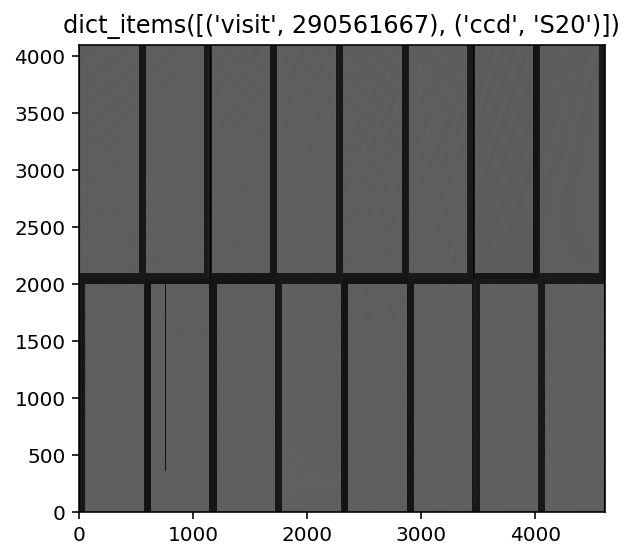

In [7]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

disp.mtv(raw, title=dataId.items())

I mentioned that the camera knows about the detector geometry.  Let's overlay that (and I'll zoom in so we can see what's going on if the display backend permits).  If you look at the help string you'll find that the colours are:
-   HorizontalPrescan      YELLOW
-   HorizontalOverscan     RED
-   Data                   BLUE
-   VerticalOverscan       MAGENTA
for each amplifier (and also MAGENTA for the entire chip, but I'm going to change that as it's confusing)

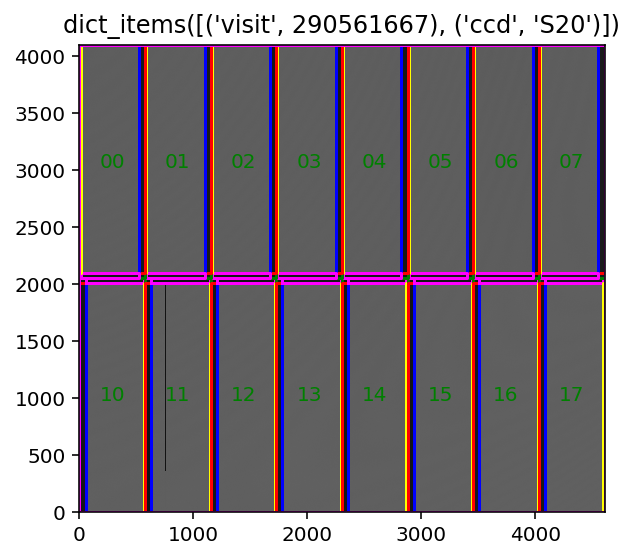

In [8]:
disp = afwDisplay.Display(1)    # you only need this in every cell because I'm using %matplotlib notebook. DM Bug??
disp.scale('asinh', 'zscale')

disp.mtv(raw, title=dataId.items())
cameraGeomUtils.overlayCcdBoxes(raw.getDetector(), display=disp)

try:
    disp.zoom(10, 350, 300)
except AttributeError as e:
    pass   # bug in display_matplotlib; doesn't work with `inline` in jupyter.  Ticket DM-13475; fixed 2018-02-02

Now let's trim the overscan and just show the data.  There are a number of ways to do this, all of which call the same code at the backend but behind different levels of syntactic sugar.

Here's a generic command that can actually do a lot more than show an assembled CCD image.  It's reading the data, subtracting the median of each overscan region, assembling the image, and displaying it on `disp`.

You might think that we could provide *more* sugar, and I agree.

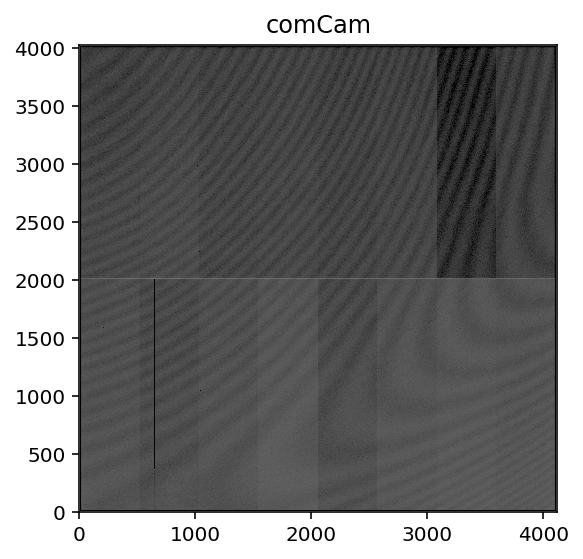

In [9]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

cameraGeomUtils.showCamera(camera,
                           cameraGeomUtils.ButlerImage(butler, "raw", visit=dataId["visit"],
                                                       callback=cameraGeomUtils.rawCallback),
                                 binSize=1, detectorNameList=[dataId["ccd"]], overlay=False, display=disp);

Now use the same command to show the entire raft, binned 32x32

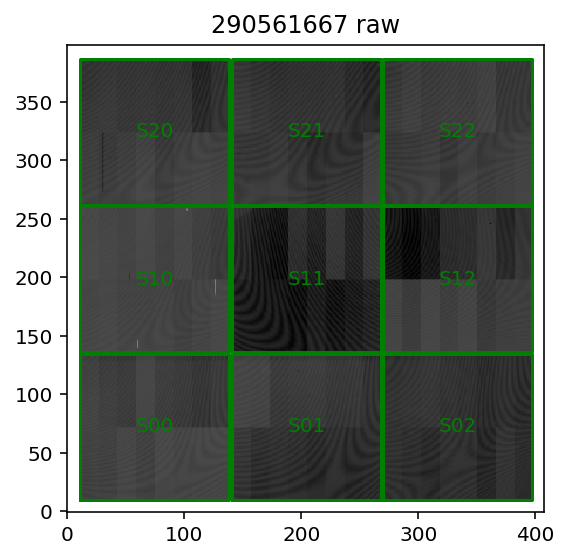

In [10]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

dataType = "raw"
mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, visit=dataId["visit"],
                                                             callback=cameraGeomUtils.rawCallback),
                                 binSize=32, display=disp, title="%d %s" % (visit, dataType))

It'd be easier to see if we corrected for the gains.  I'll run a full ISR in a moment (overscan, bias, dark, flat), but for now we'll subtract the median of each amp.

We *do* actually divide by the gain, but they are all set to 1.0 for now.  We used to use eotest values from some test run or other and some were 0 which made things significantly worse!

To do this, we'll define a custom callback:

In [11]:
def myCallback(im, ccd, imageSource, subtractMedian=True):
    """Assemble the CCD image, subtracting the overscan and subtracting each amp's median"""

    oim = cameraGeomUtils.rawCallback(im, ccd, imageSource,
                                       subtractBias=True, correctGain=False)
    if subtractMedian:
        for a in ccd:
            arr = oim[a.getBBox()].array
            arr -= np.median(arr)

    return oim

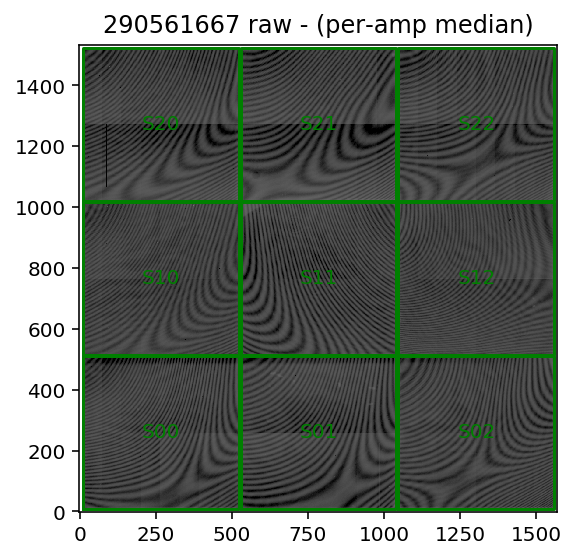

In [12]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

dataType = "raw"
mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, visit=dataId["visit"],
                                                             callback=myCallback),
                                 binSize=8, display=disp, title="%d %s - (per-amp median)" % (visit, dataType))

I mentioned that there were various ways to trim and assemble the CCDs.  Here's the primitive that we use, and for a change I'll display it on ds9 (if you don't have ds9 running, remove the `"ds9"` from the `Display` call).

We'll run the full Instrument Signature Removal (ISR) code in a little bit, but this is the basic pattern

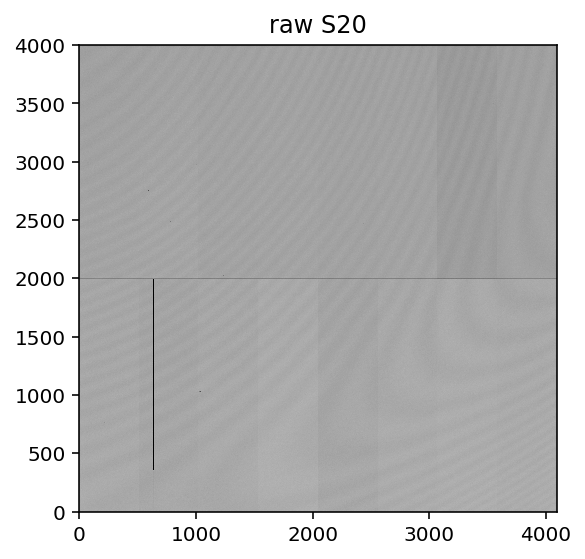

In [13]:
from lsst.ip.isr import AssembleCcdTask

config = AssembleCcdTask.ConfigClass()          # Configuration options
config.doTrim = True

assembleTask = AssembleCcdTask(config=config)   # Build the object that'll do the work -- basically a functor

raw = butler.get('raw', visit=visit, ccd='S20')
exposure = assembleTask.assembleCcd(raw)        # Do the work.

disp = afwDisplay.Display(2, "matplotlib")

disp.mtv(exposure, title="raw S20")

I talked about raw and rawish stack data;  let's look at some master calibration files (and I'll turn off the overlay)

There is magic here.  I specify the *data*'s visit number, and the butler returns the correct bias/dark/flat.  The underlying code is e.g. `butler.get('flat', visit=269921586, ccd='S20')` (where I've chosen to unpack the `dataId`)

Here I'm looking at the whole raft -- I could have used e.g. `detectorNameList=['S21', 'S22']` to look at only selected chips.

In [14]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

dataType = ["bias", "dark", "flat"][0]
mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, visit=dataId["visit"]),
                                 binSize=32, display=disp, overlay=False, title="%d %s" % (visit, dataType))

UnboundLocalError: local variable 'allowRotate' referenced before assignment

Let's write a callback to run the full ISR and mosaic up the results.  Because I don't want to read the bias and dark frames for each chip repeatedly (and am too lazy to cache them, and the caching in the butler is currently disabled due to concerns with constness) I'm actually going to turn the bias/dark processing off.

This is not beautiful;  there's a DM issue in Jira to make it easier.

In [15]:
from lsst.ip.isr import IsrTask

config = IsrTask.ConfigClass()
config.doBias = False
config.doDark = False
config.doFringe = False
config.doLinearize = False
config.doDefect = False

isrTask = IsrTask(config=config)

def isrCallback(im, ccd, imageSource, isrTask=isrTask):
    """Run the ISR"""
    dataId = imageSource.kwargs.copy()    # this is the ugly bit
    dataId['ccd'] = ccd.getName()

    if True:   # Avoid re-reading the data by reconstructing the Exposure; this is an ugly bit too
        import lsst.afw.image as afwImage

        raw = afwImage.makeExposure(afwImage.makeMaskedImage(im))
        raw.setDetector(ccd)
        raw.getInfo().setVisitInfo(afwImage.VisitInfo(exposureTime=1.0))
    else:
        raw = butler.get('raw', dataId)

    flat = butler.get('flat', dataId)

    result = isrTask.run(raw, flat=flat)    # Returns a struct;  result.exposure is an Exposure

    return result.exposure.image

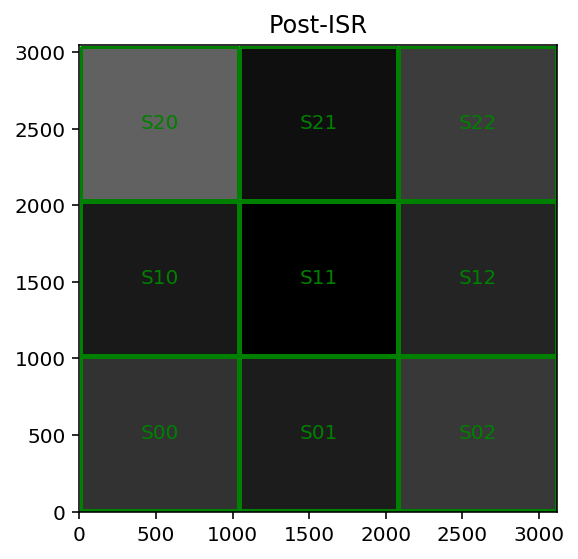

In [16]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

mos = cameraGeomUtils.showCamera(camera, 
                                 cameraGeomUtils.ButlerImage(butler, "raw", visit=visit,
                                                             callback=isrCallback), 
                                 binSize=4,
                                 display=disp, title="Post-ISR")

Let's use our knowledge of the detector to make a histogram of the difference between serial and parallel overscan levels for all the CCDs in the raft.

This is just an example; the `raw[amp.getRawHorizontalOverscanBBox()]` returns an image of the overscan for that amp, and the `.array` returns a `numpy` view of the pixels.

In [17]:
names = []
parallelOverscan = []
serialOverscan   = []
for ccd in camera:
    raw = butler.get('raw', dataId, ccd=ccd.getName())
    for amp in raw.getDetector():
        names.append("%s-%s" % (ccd.getName(), amp.getName()))
        # Serial overscan
        overscan = raw[amp.getRawHorizontalOverscanBBox()].image
        serialOverscan.append(np.median(overscan.array))
        # Parallel overscan (all on one line)
        parallelOverscan.append(np.median(raw[amp.getRawVerticalOverscanBBox()].image.array))
                
names = np.array(names)
parallelOverscan = np.array(parallelOverscan)
serialOverscan   = np.array(serialOverscan)

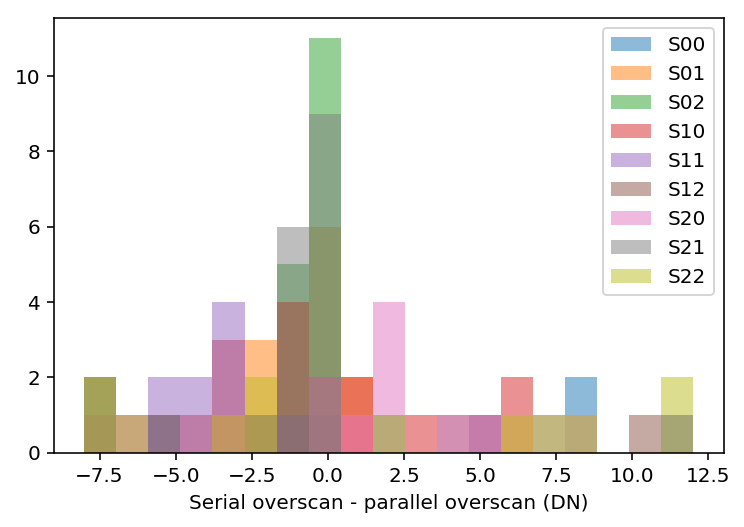

In [18]:
for ccd in [ccd.getName() for ccd in camera]:
    l = np.char.rfind(names, ccd, 0) == 0
    plt.hist((parallelOverscan - serialOverscan)[l], bins=np.linspace(-8, 12, 20), alpha=0.5, label=ccd)

plt.legend()
plt.xlabel("Serial overscan - parallel overscan (DN)");